In [58]:
!pip install graphviz

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
import datetime
import os

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('/content/drive/MyDrive/onfit_data/extracted_text.txt', 'r', encoding='utf-8') as f:
    extracted_text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(extracted_text)))
vocab_size = len(chars)
## create a mapping from characters to integers
# stoi = { ch:i for i,ch in enumerate(chars) }
# itos = { i:ch for i,ch in enumerate(chars) }
# encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
def encode(text_seq: str, tokenizer: any) -> torch.Tensor:
    """
    Function to encode input text using a pre-trained tokenizer and vectorized lookups
    """
    # tokenize the input text
    tokens = tokenizer.tokenize(text_seq)
    # convert the tokens to their corresponding ids
    token_indices = tokenizer.convert_tokens_to_ids(tokens)
    token_indices = torch.tensor(token_indices, dtype=torch.long)
    return token_indices


def decode(enc_sec: torch.Tensor, tokenizer: any) -> str:
    """
    Function to decode a sequence of token indices back to a string
    """
    # convert the indices to a list
    enc_sec = enc_sec.tolist()
    # decode the indices to a string
    text = tokenizer.decode(enc_sec)
    return text

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

# Train and test splits
data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)


# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# total_params = sum(p.numel() for p in m.parameters()) / 1e6
# print(total_params, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0], tokenizer))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (13924 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-2-20797a843014>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)


4.138682 M parameters
step 0: train loss 10.4992, val loss 10.5192
step 500: train loss 2.8885, val loss 4.6111
step 1000: train loss 1.4695, val loss 5.1071
step 1500: train loss 0.6969, val loss 5.8542
step 2000: train loss 0.4459, val loss 6.5046
step 2500: train loss 0.3666, val loss 6.9389
step 3000: train loss 0.3079, val loss 7.2229
step 3500: train loss 0.2927, val loss 7.5043
step 4000: train loss 0.2742, val loss 7.7108
step 4500: train loss 0.2643, val loss 7.8658
step 4999: train loss 0.2463, val loss 7.8677
[PAD] tes ( 2tablespoon mayonnaise 4 ounces small cauliflower florets 2 cups shredded green leaf lettuce ¥ % cup low fat cheese directions step1 drain and reserve syrup from pear halves. step 2 whisk reserved syrup and 2 tablespoons plus 1 teaspoon mayonnaise in a small bowl. place cauliflower florets in the dressing for 5 minutes. step 3 divide pear halves and lettuce between 2 cloves brush topsand step 3 tbsp minced and 1 / 4 chicken broth and stir in the tomato mixtu

In [ ]:
torch.save(m.state_dict(), 'trained_model.pth')

In [ ]:
m.load_state_dict(torch.load("/content/trained_model.pth"))
m.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(30522, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

In [ ]:
prompt = 'In a bowl, add grated carrot, onion pieces, coriander, ginger pieces'
context = torch.tensor(encode(prompt, tokenizer), dtype=torch.long, device=device)
generated_chars = (decode(model.generate(context.unsqueeze(0), max_new_tokens=10)[0], tokenizer))
print(generated_chars)

in a bowl, add grated carrot, onion pieces, coriander, ginger pieces, green chilies pieces, cumin seeds,


<ipython-input-58-15f7deb9fb69>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt, tokenizer), dtype=torch.long, device=device)


# BLEU Score

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00


In [ ]:
from datasets import load_metric
bleu_metric = load_metric('bleu')

<ipython-input-5-0ef6efd1893a>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('bleu')
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for bleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/bleu/bleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


10 inputs 10 outputs

In [ ]:
prompt1 = 'In a bowl, add grated carrot, onion pieces, coriander, ginger pieces'
context = torch.tensor(encode(prompt1, tokenizer), dtype=torch.long, device=device)
generated_chars1 = (decode(m.generate(context.unsqueeze(0), max_new_tokens=10)[0], tokenizer))
print(generated_chars1)

in a bowl, add grated carrot, onion pieces, coriander, ginger pieces, green chilies pieces, cumin seeds,


<ipython-input-55-8ac69651535d>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt1, tokenizer), dtype=torch.long, device=device)


In [ ]:
predicted1 = "green chilies pieces, cumin seeds"
reference1 = "green chilies pieces, cumin seeds, mix well and keep aside"

In [ ]:
bleu_scores = bleu_metric.compute(predictions=[predicted10.split(' ')],references=[[reference10.split(' ')]])
print(bleu_scores)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 10, 'reference_length': 10}


In [ ]:
prompt2 = 'add a cup of cold water and use an immersion'
context = torch.tensor(encode(prompt2, tokenizer), dtype=torch.long, device=device)
generated_chars = (decode(m.generate(context.unsqueeze(0), max_new_tokens=20)[0], tokenizer))
print(generated_chars)

<ipython-input-20-d5cfa2a815c7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt1, tokenizer), dtype=torch.long, device=device)


add a cup of cold water and use an immersion blend to blend to a smooth consistency or transfer to a blender and blend into a very smooth paste


10 inputs, 20 outputs

In [ ]:
predicted20 = "blend to blend to a smooth consistency or transfer to a blender and blend into a very smooth paste"
reference20 = "blender to blend to a smooth consistency or transfer to a blender and blend into a very smooth paste. Use"

In [ ]:
bleu_scores20 = bleu_metric.compute(predictions=[predicted10.split(' ')],references=[[reference10.split(' ')]])
print(bleu_scores20)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.0, 'translation_length': 10, 'reference_length': 10}


10 inputs, 30 outputs

In [ ]:
prompt3 = 'Transfer the mixture into a deep bowl and knead into'
context = torch.tensor(encode(prompt3, tokenizer), dtype=torch.long, device=device)
generated_chars3 = (decode(m.generate(context.unsqueeze(0), max_new_tokens=30)[0], tokenizer))
print(generated_chars3)

<ipython-input-26-fd0fda5c5ca4>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt3, tokenizer), dtype=torch.long, device=device)


transfer the mixture into a deep bowl and knead into a soft dough using 1 to 2 tbsp of water if needed. 3. divide the dough into 7 equal portions. 4. take a portion the


In [ ]:
predicted3 = "a soft dough using 1 to 2 tbsp of water if needed. 3. divide the dough into 7 equal portions. 4. take a portion the"
reference3 = "a soft dough using 1 to 2 tbsp of water if needed. 3. Divide the dough into 7 equal portions.4. Take a portion the dough, flatten it slightly and place"

In [ ]:
bleu_scores3 = bleu_metric.compute(predictions=[predicted3.split(' ')],references=[[reference3.split(' ')]])
print(bleu_scores3)

{'bleu': 0.5633220331122067, 'precisions': [0.84, 0.75, 0.6521739130434783, 0.5454545454545454], 'brevity_penalty': 0.8187307530779819, 'length_ratio': 0.8333333333333334, 'translation_length': 25, 'reference_length': 30}


In [ ]:
prompt4 = 'Heat a non-stick tava (griddle) on a medium flame'
context = torch.tensor(encode(prompt4, tokenizer), dtype=torch.long, device=device)
generated_chars4 = (decode(model.generate(context.unsqueeze(0), max_new_tokens=40)[0], tokenizer))
print(generated_chars4)

<ipython-input-30-bd589bba2b08>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt4, tokenizer), dtype=torch.long, device=device)


heat a non - stick tava ( griddle ) on a medium flame and when hot, place the jowar roti gently over it. 6. cook it till small blisters appear on the surface. turn over the jowar roti and cook for few more


In [ ]:
predicted4 = "and when hot, place the jowar roti gently over it. 6. cook it till small blisters appear on the surface. turn over the jowar roti and cook for few more"
reference4 = "and when hot, place the jowar roti gently over it. 6. Cook it till small blisters appear on the surface. Turn over the jowar roti and cook for few more seconds. 7. Cook the jowar roti on an open flame"

In [ ]:
bleu_scores4 = bleu_metric.compute(predictions=[predicted4.split(' ')],references=[[reference4.split(' ')]])
print(bleu_scores4)

{'bleu': 0.5851854119872504, 'precisions': [0.9333333333333333, 0.8620689655172413, 0.7857142857142857, 0.7037037037037037], 'brevity_penalty': 0.7165313105737893, 'length_ratio': 0.75, 'translation_length': 30, 'reference_length': 40}


In [ ]:
prompt5 = 'Blend avocado and the fried onion, garlic and chilli mix'
context = torch.tensor(encode(prompt5, tokenizer), dtype=torch.long, device=device)
generated_chars5 = (decode(model.generate(context.unsqueeze(0), max_new_tokens=50)[0], tokenizer))
print(generated_chars5)

<ipython-input-33-366b99ffce28>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt5, tokenizer), dtype=torch.long, device=device)


blend avocado and the fried onion, garlic and chilli mix with % cup of water in a blender. pour the puree into the pan and add salt and the remaining water and let it boil in low flame. switch of the gas once they start to splutter, add onions in the pan.


In [ ]:
predicted5 = "with % cup of water in a blender. pour the puree into the pan and add salt and the remaining water and let it boil in low flame. switch of the gas once they start to splutter, add onions in the pan."
reference5 = "with % cup of water in a blender. Pour the puree into the pan and add salt and the remaining water and let it boil in low flame. Switch of the gas once you see the soup becoming frothy. Take a hand mortar, add 1 spoon of olive oil and"

In [ ]:
bleu_scores5 = bleu_metric.compute(predictions=[predicted5.split(' ')],references=[[reference5.split(' ')]])
print(bleu_scores5)

{'bleu': 0.5451254652656135, 'precisions': [0.7857142857142857, 0.6829268292682927, 0.625, 0.5641025641025641], 'brevity_penalty': 0.8265654376242381, 'length_ratio': 0.84, 'translation_length': 42, 'reference_length': 50}


In [ ]:
prompt6 = 'To make quick paneer sabzi, combine the red chillies and'
context = torch.tensor(encode(prompt6, tokenizer), dtype=torch.long, device=device)
generated_chars6 = (decode(model.generate(context.unsqueeze(0), max_new_tokens=60)[0], tokenizer))
print(generated_chars6)

<ipython-input-37-72f6264d2383>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt6, tokenizer), dtype=torch.long, device=device)


to make quick paneer sabzi, combine the red chillies and coriander seeds in 8 sy esr ge a small broad non - stick pan and dry roast on a slow flame for 1 minute. keep aside to cool slightly. 2. blend in a mixer to a smooth fine powder and keep aside. 3. heat the oil in a non - stick ka


In [ ]:
predicted6 = "coriander seeds in 8 sy esr ge a small broad non - stick pan and dry roast on a slow flame for 1 minute. keep aside to cool slightly. 2. blend in a mixer to a smooth fine powder and keep aside. 3. heat the oil in a non - stick ka"
reference6 = "coriander seeds in 8 Sy esr Ge a small broad non-stick pan and dry roast on a slow flame for 1 minute. Keep aside to cool slightly. 2. Blend in a mixer to a smooth fine powder and keep aside. 3. Heat the oil in a non-stick kadhai and add the cumin seeds. 4. When the seeds crackle,"

In [ ]:
bleu_scores6 = bleu_metric.compute(predictions=[predicted6.split(' ')],references=[[reference6.split(' ')]])
print(bleu_scores6)

{'bleu': 0.5190909349736893, 'precisions': [0.7692307692307693, 0.6470588235294118, 0.54, 0.42857142857142855], 'brevity_penalty': 0.8910233766955563, 'length_ratio': 0.896551724137931, 'translation_length': 52, 'reference_length': 58}


In [ ]:
prompt7 = 'Season chicken on both sides with salt and pepper. Heat'
context = torch.tensor(encode(prompt7, tokenizer), dtype=torch.long, device=device)
generated_chars7 = (decode(m.generate(context.unsqueeze(0), max_new_tokens=70)[0], tokenizer))
print(generated_chars7)

<ipython-input-41-e30a40f5b62b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt7, tokenizer), dtype=torch.long, device=device)


season chicken on both sides with salt and pepper. heat olive oil in a heavy skillet over medium - high heat. 2. add in cooking oil and saute until hot the butter and oil bit of butter or until broccoli gets cooked but still crunchy. 7. * pulse chicken directions — 7. = = = a a ni e chickenw relivhealthy. com n


In [ ]:
predicted7 = "olive oil in a heavy skillet over medium - high heat. 2. add in cooking oil and saute until hot the butter and oil bit of butter or until broccoli gets cooked but still crunchy. 7. * pulse chicken directions — 7. = = = a a ni e chickenw relivhealthy. com n"
reference7 = "olive oil in a heavy skillet over medium- high heat until it starts to shimmer. Place chicken breasts skin-side down in the skillet. Sprinkle with fresh herbs. Cook until the bottoms are well seared and golden brown, 5 to We Flip chicken breasts over and continue cooking until an instant-read thermometer inserted into the center of a breast reads 150 degrees F (66 degrees C), about 5 minutes."

In [ ]:
bleu_scores7 = bleu_metric.compute(predictions=[predicted7.split(' ')],references=[[reference7.split(' ')]])
print(bleu_scores7)

{'bleu': 0.09976887078261651, 'precisions': [0.33962264150943394, 0.11538461538461539, 0.09803921568627451, 0.08], 'brevity_penalty': 0.7535055706393545, 'length_ratio': 0.7794117647058824, 'translation_length': 53, 'reference_length': 68}


In [ ]:
prompt8 = 'Flip chicken breasts over and continue cooking until an'
context = torch.tensor(encode(prompt8, tokenizer), dtype=torch.long, device=device)
generated_chars8 = (decode(m.generate(context.unsqueeze(0), max_new_tokens=80)[0], tokenizer))
print(generated_chars8)

<ipython-input-46-393c99c92f23>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt8, tokenizer), dtype=torch.long, device=device)


flip chicken breasts over and continue cooking until an instant - read thermometer inserted into the center of a breast reads 150 degrees f ( 66 degrees c ), about 5 minutes. add lemon zest and season with salt and ’ pepper * we specialize in remission / reversal of diabetes and obesity along with psychology counselling ms “ hi reliv healthy @ fra © i | “ relivhere * we specialize in re


In [ ]:
predicted8 = "instant - read thermometer inserted into the center of a breast reads 150 degrees f ( 66 degrees c ), about 5 minutes. add lemon zest and season with salt and ’ pepper * we specialize in remission / reversal of diabetes and obesity along with psychology counselling ms “ hi reliv healthy @ fra © i | “ relivhere * we specialize in re"
reference8 = "instant-read thermometer inserted into the center of a breast reads 150 degrees F (66 degrees C), about 5 minutes. Add vinegar and cold butter to the pan with chicken. Shake the pan gently until butter melts and the internal temperature of chicken reads at least 165 degrees F (74 degrees C), 2to3 eee ae Stir in 1 tablespoon chicken broth to thin sauce *We Specialize in Remission/ Reversal of Diabetes and Obesity along with Psychology Counselling Easy Glazed Salmon"

In [ ]:
bleu_scores8 = bleu_metric.compute(predictions=[predicted8.split(' ')],references=[[reference8.split(' ')]])
print(bleu_scores8)

{'bleu': 0.15961158227778197, 'precisions': [0.36923076923076925, 0.203125, 0.15873015873015872, 0.12903225806451613], 'brevity_penalty': 0.8062312915788895, 'length_ratio': 0.8227848101265823, 'translation_length': 65, 'reference_length': 79}


In [ ]:
prompt9 = 'boneless skinless chicken breasts, diced into 1 inch cubes olive'
context = torch.tensor(encode(prompt9, tokenizer), dtype=torch.long, device=device)
generated_chars9 = (decode(m.generate(context.unsqueeze(0), max_new_tokens=90)[0], tokenizer))
print(generated_chars9)

<ipython-input-50-d01cb0f87cb1>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  context = torch.tensor(encode(prompt9, tokenizer), dtype=torch.long, device=device)


boneless skinless chicken breasts, diced into 1 inch cubes olive oil cup low - sodium soy sauce cup water honey packed light brown } combine the brown sugar rice at least 1 piece and water 4 tsp black pepper., add the mint and put sauce. this 4 a slotted spoon vegetable or lolo — milk 10mins in a paste. bowl and season the right temperature of butter or bit of butter or butter or until sauce in a large skillet over medium heat. add the oil and the butter.


In [ ]:
predicted9 = "oil cup low - sodium soy sauce cup water honey packed light brown } combine the brown sugar rice at least 1 piece and water 4 tsp black pepper., add the mint and put sauce. this 4 a slotted spoon vegetable or lolo — milk 10mins in a paste. bowl and season the right temperature of butter or bit of butter or butter or until sauce in a large skillet over medium heat. add the oil and the butter."
reference9 = " oil cup low-sodium soy sauce cup water honey packed light brown sugar rice vinegar toasted sesame oil peeled and minced fresh ginger peeled and minced fresh garlic (2 cloves) Small amount of starch Sesame seeds and chopped green onions, for serving (optional) B www.relivhealthy.com @O 9000767060 Instructions 1. Heat olive oil ina 12-inch non-stick skillet over medium-high heat. 2. Add in chicken and let brown on bottom about 3 -4 minutes then flip and continue to cook until center registers about 160 degrees"

In [ ]:
bleu_scores9 = bleu_metric.compute(predictions=[predicted9.split(' ')],references=[[reference9.split(' ')]])
print(bleu_scores9)

{'bleu': 0.1187611781859016, 'precisions': [0.3037974683544304, 0.14102564102564102, 0.09090909090909091, 0.06578947368421052], 'brevity_penalty': 0.9386701501888537, 'length_ratio': 0.9404761904761905, 'translation_length': 79, 'reference_length': 84}


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
import datetime
import os

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('/content/drive/MyDrive/onfit_data/extracted_text.txt', 'r', encoding='utf-8') as f:
    extracted_text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(extracted_text)))
vocab_size = len(chars)
## create a mapping from characters to integers
# stoi = { ch:i for i,ch in enumerate(chars) }
# itos = { i:ch for i,ch in enumerate(chars) }
# encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
def encode(text_seq: str, tokenizer: any) -> torch.Tensor:
    """
    Function to encode input text using a pre-trained tokenizer and vectorized lookups
    """
    # tokenize the input text
    tokens = tokenizer.tokenize(text_seq)
    # convert the tokens to their corresponding ids
    token_indices = tokenizer.convert_tokens_to_ids(tokens)
    token_indices = torch.tensor(token_indices, dtype=torch.long)
    return token_indices


def decode(enc_sec: torch.Tensor, tokenizer: any) -> str:
    """
    Function to decode a sequence of token indices back to a string
    """
    # convert the indices to a list
    enc_sec = enc_sec.tolist()
    # decode the indices to a string
    text = tokenizer.decode(enc_sec)
    return text

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

# Train and test splits
data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model1 = BigramLanguageModel()
m1 = model1.to(device)


# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# total_params = sum(p.numel() for p in m.parameters()) / 1e6
# print(total_params, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# for iter in range(max_iters):

#     # every once in a while evaluate the loss on train and val sets
#     if iter % eval_interval == 0 or iter == max_iters - 1:
#         losses = estimate_loss()
#         print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

#     # sample a batch of data
#     xb, yb = get_batch('train')

#     # evaluate the loss
#     logits, loss = model(xb, yb)
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer.step()

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0], tokenizer))


Token indices sequence length is longer than the specified maximum sequence length for this model (13924 > 512). Running this sequence through the model will result in indexing errors


4.138682 M parameters


<ipython-input-68-2f7adbadd86f>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)


In [ ]:
kk=[]
for i in m.parameters():
  abc = i.numel()
  print(abc)
  kk.append(abc)

1953408
2048
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
4096
64
16384
256
16384
64
64
64
64
64
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
4096
64
16384
256
16384
64
64
64
64
64
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
4096
64
16384
256
16384
64
64
64
64
64
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
1024
4096
64
16384
256
16384
64
64
64
64
64
64
64
1953408
30522


In [ ]:
sum(kk)/1000000

4.138682

In [ ]:
m.parameters()

<generator object Module.parameters at 0x7fd58327b990>

In [ ]:
m1.load_state_dict(torch.load("/content/trained_model.pth"))
m1.eval()

BigramLanguageModel(
  (token_embedding_table): Embedding(30522, 64)
  (position_embedding_table): Embedding(32, 64)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=64, out_features=16, bias=False)
            (query): Linear(in_features=64, out_features=16, bias=False)
            (value): Linear(in_features=64, out_features=16, bias=False)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ffwd): FeedFoward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.0, inplace=False)
        )
      )
      (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
 

# Graphical representation of the model

In [57]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
import datetime
import os

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()

# Create a Digraph object to represent the model graph
dot = Digraph()

# Add nodes and edges for each layer
for name, param in model.named_parameters():
    dot.node(name, f"{name}\n{param.shape}")

# Add edges to represent connections between layers
for name, module in model.named_children():
    for child_name, _ in module.named_parameters():
        dot.edge(name, f"{name}.{child_name}")

# Render and save the graph
dot.render('model_parameters_graph', format='png', cleanup=True)

'model_parameters_graph.png'

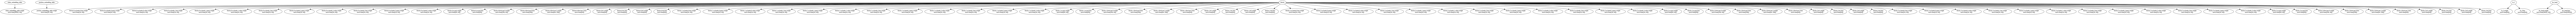

In [59]:
from IPython.display import Image
Image(filename='/content/model_parameters_graph.png')

Experimenting with the Architecture by changing the Hyper parameters

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import AutoTokenizer
import datetime
import os

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 256
n_head = 4
n_layer = 16
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('/content/drive/MyDrive/onfit_data/extracted_text.txt', 'r', encoding='utf-8') as f:
    extracted_text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(extracted_text)))
vocab_size = len(chars)
## create a mapping from characters to integers
# stoi = { ch:i for i,ch in enumerate(chars) }
# itos = { i:ch for i,ch in enumerate(chars) }
# encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
# decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string
def encode(text_seq: str, tokenizer: any) -> torch.Tensor:
    """
    Function to encode input text using a pre-trained tokenizer and vectorized lookups
    """
    # tokenize the input text
    tokens = tokenizer.tokenize(text_seq)
    # convert the tokens to their corresponding ids
    token_indices = tokenizer.convert_tokens_to_ids(tokens)
    token_indices = torch.tensor(token_indices, dtype=torch.long)
    return token_indices


def decode(enc_sec: torch.Tensor, tokenizer: any) -> str:
    """
    Function to decode a sequence of token indices back to a string
    """
    # convert the indices to a list
    enc_sec = enc_sec.tolist()
    # decode the indices to a string
    text = tokenizer.decode(enc_sec)
    return text

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

# Train and test splits
data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)


# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# total_params = sum(p.numel() for p in m.parameters()) / 1e6
# print(total_params, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# for iter in range(max_iters):

#     # every once in a while evaluate the loss on train and val sets
#     if iter % eval_interval == 0 or iter == max_iters - 1:
#         losses = estimate_loss()
#         print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

#     # sample a batch of data
#     xb, yb = get_batch('train')

#     # evaluate the loss
#     logits, loss = model(xb, yb)
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer.step()

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# print(decode(m.generate(context, max_new_tokens=2000)[0], tokenizer))


Token indices sequence length is longer than the specified maximum sequence length for this model (13924 > 512). Running this sequence through the model will result in indexing errors
<ipython-input-91-0f18b664bb26>:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(encode(extracted_text, tokenizer), dtype=torch.long)


28.290362 M parameters
